# Machine Learning–Based Forecasting of Bond Market Returns

   ## Lucss Li

## Project Overview

This project builds a machine learning pipeline to predict daily bond market index return direction (up/down) based on various financial indicators, including lagged returns, volatility, momentum, moving averages, and long-term percent-change signals.

The goal is to evaluate how different features contribute to predictive power and compare the performance between Logistic Regression and Random Forest models.

In [552]:
! pip install lightgbm
! pip install -U lightgbm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [553]:
! pip install --upgrade lightgbm
! pip install pandas pyarrow

### Data Overview

BofA Merrill Lynch Total Bond Return Index Values dataset tracks the performance of US dollar denominated below investment grade rated corporate debt publicly issued in the US domestic market. To qualify for inclusion in the index, securities must have a below investment grade rating (based on an average of Moody's, S&P, and Fitch) and an investment grade rated country of risk (based on an average of Moody's, S&P, and Fitch foreign currency long term sovereign debt ratings). 

### Raw Data
'observation_date', 
'level',
'continously_compounded_annual_rate_of_change',
'continuously_compouded_rate_of_change', 
'change_from_year_ago',
'change', 
'natural_log', 
'percent_change_from_year_ago',
'compounded_annual_rate _of_change', 
'percent_change', 
'year', 
'month',
'day'

In [554]:
df=pd.read_excel("/Users/billli/Desktop/bofa corporate bond index.xlsx")
print(df.head(15))

    observation_date    level  continously_compounded_annual_rate_of_change  \
0              45292      NaN                                           NaN   
1              45293  3225.86                                           NaN   
2              45294  3224.25                                     -12.97962   
3              45295  3206.83                                    -140.85382   
4              45296  3198.29                                     -69.33208   
5              45299  3211.29                                     105.46727   
6              45300  3213.41                                      17.15878   
7              45301  3214.61                                       9.70750   
8              45302  3228.38                                     111.13491   
9              45303  3235.72                                      59.04614   
10             45306  3236.88                                       9.31928   
11             45307  3214.92                       

## Data Cleaning
During the data cleaning, I looked into the codes to remove or recode variables as needed.

In [555]:
print(df['observation_date'].dtype)

int64


In [556]:
df['observation_date']=pd.to_datetime('1899-12-30') +  pd.to_timedelta(df['observation_date'], unit='D')

In [557]:
df['year']=df['observation_date'].dt.year
df['month']=df['observation_date'].dt.month
df['day']=df['observation_date'].dt.day
print(df[['observation_date','year','month','day']].head(10))

  observation_date  year  month  day
0       2024-01-01  2024      1    1
1       2024-01-02  2024      1    2
2       2024-01-03  2024      1    3
3       2024-01-04  2024      1    4
4       2024-01-05  2024      1    5
5       2024-01-08  2024      1    8
6       2024-01-09  2024      1    9
7       2024-01-10  2024      1   10
8       2024-01-11  2024      1   11
9       2024-01-12  2024      1   12


coverting the observation Date column to a more readable format

In [558]:
rows_with_missing=df[df.isnull().any(axis=1)]
print(rows_with_missing)

    observation_date    level  continously_compounded_annual_rate_of_change  \
0         2024-01-01      NaN                                           NaN   
1         2024-01-02  3225.86                                           NaN   
64        2024-03-29      NaN                                           NaN   
65        2024-03-31  3236.29                                           NaN   
66        2024-04-01  3213.44                                    -184.22554   
254       2024-12-16  3363.77                                      23.43071   
260       2024-12-24  3323.80                                      28.64566   
261       2024-12-25      NaN                                           NaN   
262       2024-12-26  3327.38                                           NaN   

     continuously_compouded_rate_of_change  change_from_year_ago  change  \
0                                      NaN                   NaN     NaN   
1                                      NaN               

In [559]:
df1=df.dropna()
df1.isna().sum()

observation_date                                0
level                                           0
continously_compounded_annual_rate_of_change    0
continuously_compouded_rate_of_change           0
change_from_year_ago                            0
change                                          0
natural_log                                     0
percent_change_from_year_ago                    0
compounded_annual_rate _of_change               0
percent_change                                  0
year                                            0
month                                           0
day                                             0
dtype: int64

The bond market was closed on 1/1/2025(new year)and 4/18/2025(Good Friday), so I removed these two rows from the dataset.

Codebook:
cusip: 9-character CUSIP identifier
exretn: current-month bond return in excess of the one-month risk-free rate of return



## Feature Engineer

In [584]:
df1['log_ret']=df1['natural_log'].diff()
df1['ret_lag1'] = df1['natural_log'].shift(1)
df1['ret_lag2'] = df1['natural_log'].shift(2)
df1['ret_lag3'] = df1['natural_log'].shift(3)
df1['ret_lag5'] = df1['natural_log'].shift(5)
df1['ret_lag10'] = df1['natural_log'].shift(10)

In [561]:
# Short-Term and 3-Day Moving Average 
df1['ma1'] = df1['level'].rolling(1).mean()
df1['ma3'] = df1['level'].rolling(3).mean()
df1['ma_diff'] = df1['ma3'] - df1['ma1']

/var/folders/w9/t_7k0_v96hxcc1nlzcyy14vw0000gn/T/ipykernel_60591/2846354088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ma1'] = df1['level'].rolling(1).mean()
/var/folders/w9/t_7k0_v96hxcc1nlzcyy14vw0000gn/T/ipykernel_60591/2846354088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ma3'] = df1['level'].rolling(3).mean()
/var/folders/w9/t_7k0_v96hxcc1nlzcyy14vw0000gn/T/ipykernel_60591/2846354088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [562]:
# momentum
df1['mom5'] = df1['log_ret'].rolling(5).sum()
df1['mom10'] = df1['log_ret'].rolling(10).sum()

/var/folders/w9/t_7k0_v96hxcc1nlzcyy14vw0000gn/T/ipykernel_60591/2337053145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mom5'] = df1['log_ret'].rolling(5).sum()
/var/folders/w9/t_7k0_v96hxcc1nlzcyy14vw0000gn/T/ipykernel_60591/2337053145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mom10'] = df1['log_ret'].rolling(10).sum()


In [811]:
# Volatility
df1['vol3'] = df1['log_ret'].rolling(3).std()
df1['vol5'] = df1['log_ret'].rolling(5).std()
df1['vol10'] = df1['log_ret'].rolling(10).std()

In [564]:
print(df1.head(20))

   observation_date    level  continously_compounded_annual_rate_of_change  \
2        2024-01-03  3224.25                                     -12.97962   
3        2024-01-04  3206.83                                    -140.85382   
4        2024-01-05  3198.29                                     -69.33208   
5        2024-01-08  3211.29                                     105.46727   
6        2024-01-09  3213.41                                      17.15878   
7        2024-01-10  3214.61                                       9.70750   
8        2024-01-11  3228.38                                     111.13491   
9        2024-01-12  3235.72                                      59.04614   
10       2024-01-15  3236.88                                       9.31928   
11       2024-01-16  3214.92                                    -176.99315   
12       2024-01-17  3207.31                                     -61.61726   
13       2024-01-18  3203.76                                    

In [565]:
df1=df1.dropna()
df1.isna().sum()

observation_date                                0
level                                           0
continously_compounded_annual_rate_of_change    0
continuously_compouded_rate_of_change           0
change_from_year_ago                            0
change                                          0
natural_log                                     0
percent_change_from_year_ago                    0
compounded_annual_rate _of_change               0
percent_change                                  0
year                                            0
month                                           0
day                                             0
log_ret                                         0
ret_lag1                                        0
ret_lag2                                        0
ret_lag3                                        0
ma1                                             0
ma3                                             0
ma_diff                                         0


In [566]:
df1['target'] = (df1['level'].shift(-5) > df1['level']).astype(int)

In [567]:
features = ['ret_lag1','ret_lag2','ret_lag3','ma_diff','vol5','vol10','percent_change_from_year_ago']
X = df1[features]
y = df1['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25)

#feature scaling
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic
logit = LogisticRegression(max_iter=1000, class_weight='balanced').fit(X_train_scaled, y_train)
log_prob = logit.predict_proba(X_test_scaled)[:,1]
print("Logistic AUC:", roc_auc_score(y_test, log_prob))

# RF
rf = RandomForestClassifier(n_estimators=250, max_depth=8, min_samples_leaf=5, random_state=42, class_weight='balanced').fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:,1]
print("RF AUC:", roc_auc_score(y_test, rf_prob))

Logistic AUC: 0.6407563025210085
RF AUC: 0.7037815126050421


The model is deigned to predict the rise/deline of bond index based on 5-day historical data. The Logistic AUC shows the model has the 83.33% chance to assign going-up for a day that actually went up. Since the logistic regression achieved higher ROC-AUC than random forest, and the results may suggest the features are more aligned with a linear structure instead of a more complex, non-linear one given the current features and data size. Random forest might also overfitting due the limited data. 


### Testing Correlation

In [568]:
print(df1[features + ['target']].corr()['target'])

ret_lag1                       -0.108587
ret_lag2                       -0.101933
ret_lag3                       -0.106439
ma_diff                         0.033589
vol5                           -0.083437
vol10                           0.063534
percent_change_from_year_ago   -0.053431
target                          1.000000
Name: target, dtype: float64


In [569]:
df1[['percent_change_from_year_ago','target']].corr()

,percent_change_from_year_ago,target
percent_change_from_year_ago,1.000000,-0.053431
target,-0.053431,1.000000


LightGBM

In [804]:
df1['vol_ewm4'] = df1['log_ret'].ewm(span=4).std()

In [785]:
df1['rsi'] = ta.momentum.RSIIndicator(df['level'], window=14).rsi()

In [823]:
features = ['vol_ewm4','vol3','ret_lag5','rsi']
X = df1[features]
y = df1['target']

# TimeSeries Split
tscv = TimeSeriesSplit(n_splits=5)
auc_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # LightGBM Training
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

    model = lgb.LGBMClassifier (
        objective= 'binary',
        learning_rate= 0.05,
        num_leaves= 20,
        max_depth= 5,
        feature_fraction= 0.8,
        bagging_fraction= 0.8,
        bagging_freq= 5,
        n_estimators= 300,
        verbose=-1,
        reg_alpha=1,
        random_state= 42
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(50)]
    )


    y_pred_prob = model.predict_proba(X_test)[:,1]

    auc = roc_auc_score(y_test, y_pred_prob)

    auc_scores.append(auc)


    print(f"Fold AUC: {auc:.3f}")

print(f"Average AUC: {np.mean(auc_scores):.3f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.693513
Fold AUC: 0.500
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.648438	valid_0's binary_logloss: 0.669559
Fold AUC: 0.648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.683333	valid_0's binary_logloss: 0.657062
Fold AUC: 0.683
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's auc: 0.761905	valid_0's binary_logloss: 0.724639
Fold AUC: 0.762
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.843137	valid_0's binary_logloss: 0.574513
Fold AUC: 0.843
Average AUC: 0.687


In [815]:
df1[features].describe()

,vol_ewm4,vol3,ret_lag3,ret_lag5,rsi
count,195.000000,194.000000,194.000000,192.000000,197.000000
mean,0.003198,0.002965,8.104142,8.104089,54.105095
std,0.001368,0.001794,0.024823,0.024947,12.514673
min,0.001179,0.000215,8.054970,8.054970,22.528316
25%,0.002268,0.001731,8.081962,8.081875,43.060445
50%,0.002915,0.002554,8.110715,8.110970,56.719932
75%,0.003783,0.003897,8.125822,8.126090,63.820125
max,0.009663,0.010636,8.143650,8.143650,78.574970


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

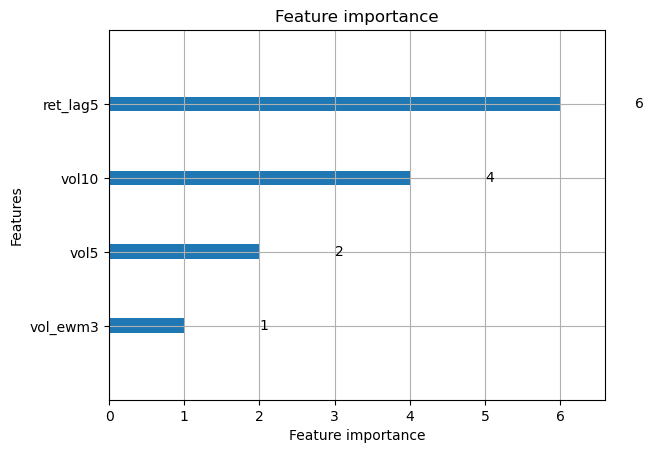

In [586]:
lgb.plot_importance(model, max_num_features=20)

In [912]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=42)

pi = pd.DataFrame({
    'feature': X_test.columns,
    'importance': r.importances_mean
}).sort_values(by='importance', ascending=False)

print(pi)


    feature  importance
2  ret_lag5    0.287799
0  vol_ewm4    0.055263
3       rsi   -0.000718
1      vol3   -0.010407


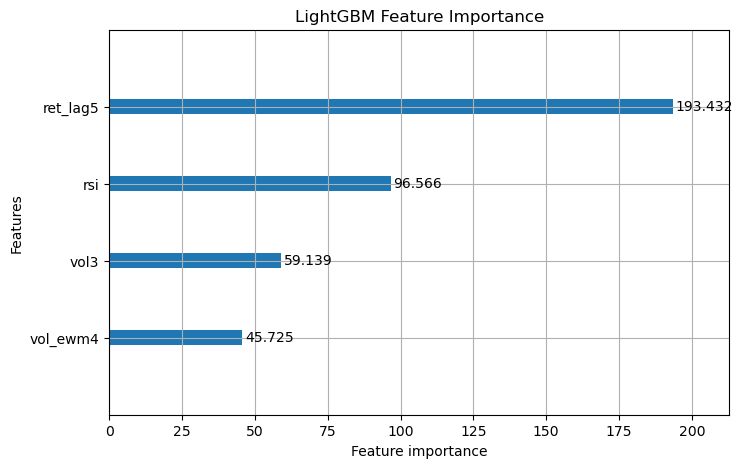

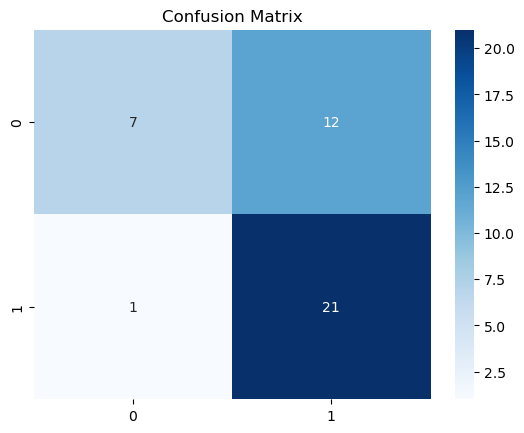

In [914]:
#Feature Importance Plot
lgb.plot_importance(model, max_num_features=10, importance_type='gain', figsize=(8,5))
plt.title("LightGBM Feature Importance")
plt.show()

#Confusion Matrix
y_pred_class = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()